# Part I: Data Wrangling
## Data Gathering

In [1]:
# Importing required Libraries
import pandas as pd
import numpy as np
import tweepy
import requests
import re
import json
import matplotlib.pyplot as plt
import datetime as dt
import os
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 1) WeRateDogs Twitter Archive
Reading a manually downloaded `CSV` file, using pandas `read_csv()`.

In [2]:
# Import the WeRateDogs Twitter Archive into a DataFrame
archive_df = pd.read_csv('twitter_archive_enhanced.csv')

In [3]:
# Check to see if the file was imported correctly
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


## 2) Tweet Image Predictions
Programmatically download the tweet image predictions using the `Requests` library.

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [5]:
# Create file if it doesn't already exist
file_name = 'image-predictions.tsv'
if not os.path.isfile(file_name):
    # Write content to file
    with open(file_name, mode='wb') as file:
              file.write(response.content)

In [6]:
# Read the tweet image predictions TSV file into a DataFrame
img_pred_df = pd.read_csv(file_name, sep='\t')
# Check to see if the file was imported correctly
img_pred_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


## 3) Additional Data via the Tweepy API
Getting the **retweet count** and **favorite count** via the Tweepy API.

In [10]:
# Library to read secret credentials
from dotenv import load_dotenv
load_dotenv()

True

In [11]:
consumer_key = os.getenv('MY_CONSUMER_KEY')
consumer_secret = os.getenv('MY_CONSUMER_SECRET')
access_token = os.getenv('MY_ACCESS_TOKEN')
access_secret = os.getenv('MY_ACCESS_SECRET')

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

### Testing the Tweepy API

In [16]:
# Experimenting to extract one tweet_id information after creating the Tweepy API object
test_tweet = api.get_status(archive_df.tweet_id[5], tweet_mode = 'extended')
tweet_content = test_tweet._json
tweet_content

{'created_at': 'Sat Jul 29 00:08:17 +0000 2017',
 'id': 891087950875897856,
 'id_str': '891087950875897856',
 'full_text': "Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh",
 'truncated': False,
 'display_text_range': [0, 138],
 'entities': {'hashtags': [{'text': 'BarkWeek', 'indices': [129, 138]}],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 891087942176911360,
    'id_str': '891087942176911360',
    'indices': [139, 162],
    'media_url': 'http://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg',
    'url': 'https://t.co/kQ04fDDRmh',
    'display_url': 'pic.twitter.com/kQ04fDDRmh',
    'expanded_url': 'https://twitter.com/dog_rates/status/891087950875897856/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'small': {'w': 680, 'h':

In [17]:
tweet_content['retweet_count']

2731

In [18]:
tweet_content['favorite_count']

18481

In [19]:
tweet_content.keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

### Querying Tweepy API to get the retweet count and favorite count

In [20]:
# List of Not Found Tweets
errors = []
# Create 'tweet_json.txt' if it doesn't exist already
if not os.path.isfile('tweet_json.txt'):
    # Write the Tweets data to the file
    with open('tweet_json.txt', mode='w') as file:
        for tweet_id in archive_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode = 'extended')
                json.dump(status._json, file)
                # Insert a new line after each tweet
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

Error on tweet id 888202515573088257;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 873697596434513921;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872668790621863937;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872261713294495745;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 869988702071779329;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 866816280283807744;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 861769973181624320;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 861383897657036800;Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Error on tweet id 856602993587888130;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 85195390

Rate limit reached. Sleeping for: 370


Error on tweet id 698549713696649216;Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))
Error on tweet id 680055455951884288;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 674036086168010753;Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


Rate limit reached. Sleeping for: 367


Error on tweet id 667152164079423490;Failed to send request: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))


### Read `tweet_json.txt` into a pandas DataFrame

In [10]:
# Initialize empty list to store tweet data
tweet_list = []
with open('tweet_json.txt', mode='r') as file:
    # Read file line by line
    filecontent = file.readlines()
    for line in filecontent:
#     tweet = file.readline()[:-1]
        tweet = line
        # Convert string into a Dictionary
        tweet_dic = json.loads(tweet)
#     print(tweet_dic['id'])
        tweet_list.append({'tweet_id': tweet_dic['id'],
                           'retweet_count': tweet_dic['retweet_count'],
                           'favorite_count': tweet_dic['favorite_count']})
        
tweepy_df = pd.DataFrame(tweet_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])
tweepy_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7386,35092
1,892177421306343426,5499,30379
2,891815181378084864,3634,22844
3,891689557279858688,7560,38360
4,891327558926688256,8145,36642


# Assess
## Visual Assessment

In [7]:
# Display the WeRateDogs Twitter archive DF
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [8]:
# Display tweet image predictions DF
img_pred_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [11]:
# Display Tweepy API DF
tweepy_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7386,35092
1,892177421306343426,5499,30379
2,891815181378084864,3634,22844
3,891689557279858688,7560,38360
4,891327558926688256,8145,36642
...,...,...,...
2321,666049248165822465,38,94
2322,666044226329800704,122,260
2323,666033412701032449,39,107
2324,666029285002620928,41,118


## Programmatic Assessment

In [12]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
# Checking for very high ratings
archive_df[archive_df['rating_numerator'] > 20]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [15]:
archive_df[archive_df['rating_denominator'] < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


In [19]:
# Checking tweets with Decimal Ratings as requested in the first project review
with pd.option_context('display.max_colwidth', None):
    display(archive_df[archive_df.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id', 'text', 'rating_numerator']])

,tweet_id,text,rating_numerator
45,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5
340,832215909146226688,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27
1689,681340665377193984,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5
1712,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26


In [99]:
# Checking tweets with Decimal Ratings in Denominator
## Note: No Denominators with decimal points, but incorrectly extracted ratings for tweet_ids: 775096608509886464, 740373189193256964, 716439118184652801
with pd.option_context('display.max_colwidth', None):
    display(archive_df[archive_df.text.str.contains(r"(\d+\/\d+\.\d*)")][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']])

,tweet_id,text,rating_numerator,rating_denominator
97,873337748698140672,RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps:/…,12,10
98,873213775632977920,This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps://t.co/Xp01EU3qyD https://t.co/V5lkvrGLdQ,12,10
184,856526610513747968,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",14,10
251,844979544864018432,"PUPDATE: I'm proud to announce that Toby is 236 days sober. Pupgraded to a 13/10. We're all very proud of you, Toby https://t.co/a5OaJeRl9B",13,10
397,825120256414846976,RT @dog_rates: Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance\n\nhttps:/…,12,10
398,825026590719483904,Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance\n\nhttps://t.co/koHvVQp9bL https://t.co/IhW0JKf7kc,12,10
742,780476555013349377,RT @Patreon: Well. @dog_rates is on Patreon. \n\n12/10. \n\nhttps://t.co/rnKvzt6RJs https://t.co/v4e2ywe8iO,12,10
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [20]:
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1176,719991154352222208,NaN,NaN,2016-04-12 20:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This doggo was initially thrilled when she saw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/719991154...,10,10,None,doggo,None,None,None
1470,694001791655137281,NaN,NaN,2016-02-01 03:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chester. He's a Benefloof Cumberbark. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/694001791...,11,10,Chester,None,None,None,None
2115,670428280563085312,NaN,NaN,2015-11-28 02:25:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Willy. He's millennial af. 11/10 https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670428280...,11,10,Willy,None,None,None,None
914,757393109802180609,NaN,NaN,2016-07-25 01:52:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo completely oblivious to the dou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/757393109...,10,10,None,doggo,None,None,None
437,820078625395449857,NaN,NaN,2017-01-14 01:22:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've never wanted to go to a camp more in my e...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820078625...,12,10,None,None,None,None,None


In [21]:
archive_df['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
           ... 
Rinna         1
Rueben        1
Jennifur      1
Jersey        1
Craig         1
Name: name, Length: 957, dtype: int64

In [22]:
archive_df[archive_df['name'] == 'a'].text

56      Here is a pupper approaching maximum borkdrive...
649     Here is a perfect example of someone who has t...
801     Guys this is getting so out of hand. We only r...
1002    This is a mighty rare blue-tailed hammer sherk...
1004    Viewer discretion is advised. This is a terrib...
1017    This is a carrot. We only rate dogs. Please on...
1049    This is a very rare Great Alaskan Bush Pupper....
1193    People please. This is a Deadly Mediterranean ...
1207    This is a taco. We only rate dogs. Please only...
1340    Here is a heartbreaking scene of an incredible...
1351    Here is a whole flock of puppers.  60/50 I'll ...
1361    This is a Butternut Cumberfloof. It's not wind...
1368    This is a Wild Tuscan Poofwiggle. Careful not ...
1382    "Pupper is a present to world. Here is a bow f...
1499    This is a rare Arctic Wubberfloof. Unamused by...
1737    Guys this really needs to stop. We've been ove...
1785    This is a dog swinging. I really enjoyed it so...
1853    This i

In [23]:
archive_df[archive_df['name'] == 'None'].text

5       Here we have a majestic great white breaching ...
7       When you watch your owner call another dog a g...
12      Here's a puppo that seems to be on the fence a...
24      You may not have known you needed to see this ...
25      This... is a Jubilant Antarctic House Bear. We...
                              ...                        
2342    Here we have a well-established sunblockerspan...
2343    Let's hope this flight isn't Malaysian (lol). ...
2344    Here we have a northern speckled Rhododendron....
2351    Here we have a 1949 1st generation vulpix. Enj...
2355    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 745, dtype: object

In [25]:
archive_df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [26]:
archive_df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [27]:
archive_df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [28]:
archive_df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [29]:
archive_df['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [30]:
archive_df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [31]:
# Tweets with no 'expanded_urls' have no image or dog rating
archive_df[archive_df['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [32]:
# Inspecting the image predictions dataframe
img_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 119.6+ KB


In [33]:
img_pred_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1327,757393109802180609,https://pbs.twimg.com/media/CoLNAq6WAAAkmdJ.jpg,2,Labrador_retriever,0.787125,True,Chesapeake_Bay_retriever,0.112676,True,Rottweiler,0.048039,True
1425,772193107915964416,https://pbs.twimg.com/media/Crdhh_1XEAAHKHi.jpg,1,Pembroke,0.367945,True,Chihuahua,0.223522,True,Pekinese,0.164871,True
1928,858107933456039936,https://pbs.twimg.com/media/C-icm_WXUAAmuRR.jpg,1,golden_retriever,0.863874,True,Labrador_retriever,0.015920,True,doormat,0.010615,False
1205,741793263812808706,https://pbs.twimg.com/media/CkthBj7WgAAsIGb.jpg,1,kuvasz,0.311325,True,French_bulldog,0.115349,True,Labrador_retriever,0.068533,True
1900,851464819735769094,https://pbs.twimg.com/media/C9ECujZXsAAPCSM.jpg,2,web_site,0.919649,False,menu,0.026306,False,crossword_puzzle,0.003482,False


In [34]:
img_pred_df['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
cuirass                 1
maillot                 1
cowboy_boot             1
restaurant              1
bakery                  1
Name: p1, Length: 378, dtype: int64

In [35]:
img_pred_df['p2'].value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
cockroach               1
Japanese_spaniel        1
white_wolf              1
television              1
hair_spray              1
Name: p2, Length: 405, dtype: int64

In [36]:
img_pred_df['p3'].value_counts()

Labrador_retriever          79
Chihuahua                   58
golden_retriever            48
Eskimo_dog                  38
kelpie                      35
                            ..
bow_tie                      1
European_fire_salamander     1
power_drill                  1
boathouse                    1
croquet_ball                 1
Name: p3, Length: 408, dtype: int64

In [37]:
img_pred_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [38]:
tweepy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2326 entries, 0 to 2325
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2326 non-null   int64
 1   retweet_count   2326 non-null   int64
 2   favorite_count  2326 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [39]:
tweepy_df.sample(5)

,tweet_id,retweet_count,favorite_count
394,822975315408461824,3352,17004
579,798682547630837760,4671,0
1477,691820333922455552,1582,3820
1373,699691744225525762,4401,9922
1915,673708611235921920,264,1002


In [40]:
tweepy_df.describe()

,tweet_id,retweet_count,favorite_count
count,2.326000e+03,2326.000000,2326.000000
mean,7.418908e+17,2590.297936,7306.249785
std,6.818638e+16,4385.379495,11353.727253
min,6.660209e+17,1.000000,0.000000
25%,6.782926e+17,527.000000,1270.750000
50%,7.183508e+17,1211.000000,3180.500000
75%,7.986600e+17,3004.000000,8946.000000
max,8.924206e+17,74523.000000,150910.000000


In [41]:
# Check for duplicated column names
all_columns = pd.Series(list(archive_df) + list(img_pred_df) + list(tweepy_df))
all_columns[all_columns.duplicated()]

17    tweet_id
29    tweet_id
dtype: object

In [42]:
all_columns

0                       tweet_id
1          in_reply_to_status_id
2            in_reply_to_user_id
3                      timestamp
4                         source
5                           text
6            retweeted_status_id
7       retweeted_status_user_id
8     retweeted_status_timestamp
9                  expanded_urls
10              rating_numerator
11            rating_denominator
12                          name
13                         doggo
14                       floofer
15                        pupper
16                         puppo
17                      tweet_id
18                       jpg_url
19                       img_num
20                            p1
21                       p1_conf
22                        p1_dog
23                            p2
24                       p2_conf
25                        p2_dog
26                            p3
27                       p3_conf
28                        p3_dog
29                      tweet_id
30        

## Quality

### `archive_df` table
1. **78** entries are **replies** and not original tweets (`in_reply_to_status_id` and `in_reply_to_user_id` has values).
2. **181** entries are **retweets** and not original tweets (`retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` has values).
3. `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns are not useful for analysis and should be removed.
4. **59** entries do not contain images (`expanded_urls` is null).
5. `tweet_id` is integer instead of string (`object`).
6. `timestamp` is a string and not `datetime`.
7. `rating_numerator` is integer instead of float.
8. **55** `dog names` incorrectly extracted as `a`, because the tweet was in the format `'This is a ...'` instead of `'This is (Dog Name)'`.
9. **745** `dog names` incorrectly extracted as `None`, because the tweet was not in the format `'This is (Dog Name)'`.
10. `tweet_id = 810984652412424192` does not include a dog rating, the `text= 'Meet Sam. She smiles 24/7 & secretly aspires to be a reindeer.'` and the rating was incorrectly extracted as `24/7`.
11. `tweet_id = 666287406224695296` rating was incorrectly extracted as `1/2` while it should be `9/10`. `text = 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. 9/10'`.
12.	**6** entries in the `rating_numerator` column were incorrectly extracted, because the original rating had *decimal points*, so only the number after the decimal point was extracted.
13. Other incorrectly extracted **ratings** for `tweet_ids: 775096608509886464, 740373189193256964, 716439118184652801`.

### `img_pred_df` table
1. `tweet_id` is integer instead of string (`object`).
2. Only **2075** image predictions are available, which indicates that another **281** tweets have no images and should be excluded from the `archive_df` table.

### `tweepy_df` table
1. `tweet_id` is integer instead of string (`object`).

## Tidiness

### `archive_df` table

1. `Dog Stages` variables split into four columns (`doggo`, `floofer`, `pupper` and `puppo`) instead of one.
2. A single observational unit (Tweet information) is stored in multiple tables (`archive_df` and `tweepy_df`).

# Clean

In [43]:
# Create copies of the DataFrames for cleaning
archive_clean = archive_df.copy()
img_pred_clean = img_pred_df.copy()
tweepy_clean = tweepy_df.copy()

## Missing Data
Handle missing data first.

### `archive`: `78` entries are replies and not original tweets

#### Define
- Remove replies from `archive` table, entries where `in_reply_to_status_id` and `in_reply_to_user_id` are not null.

#### Code

In [44]:
# Get Reply entries
reply_entries = archive_clean.in_reply_to_status_id.notnull()
archive_clean[reply_entries].shape[0]

78

In [45]:
# Drop Reply entries from archive
archive_clean = archive_clean[~reply_entries]

#### Test

In [46]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2278 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2278 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2278 non-null   object 
 4   source                      2278 non-null   object 
 5   text                        2278 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2274 non-null   object 
 10  rating_numerator            2278 non-null   int64  
 11  rating_denominator          2278 non-null   int64  
 12  name                        2278 non-null   object 
 13  doggo                       2278 

In [47]:
# Should be empty
archive_clean[archive_clean.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### `archive`: *181* entries are retweets and not original tweets 

#### Define
- Remove Retweets from `archive` table; entries where `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` are not null.

#### Code

In [48]:
# Get Retweet entries
retweet_entries = archive_clean.retweeted_status_id.notnull()
archive_clean[retweet_entries].shape[0]

181

In [49]:
# Drop Retweet entries from archive
archive_clean = archive_clean[~retweet_entries]

#### Test

In [50]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

### `archive`: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns are not useful for analysis and should be removed

#### Define
- Drop `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp` columns from `archive` table.

#### Code

In [51]:
# Specify columns to drop
columns_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
# Drop columns from archive_clean
archive_clean = archive_clean.drop(columns_to_drop, axis=1)

#### Test

In [52]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 139.3+ KB


### `archive`: **59** entries do not contain images (`expanded_urls` is null)

#### Define
- Drop entries where `expanded_urls` is null from `archive` table.

#### Code

In [53]:
# Get entries where `expanded_urls` is null
no_image_entries = archive_clean.expanded_urls.isnull()
# Only 3 entries with no images remaining after deleting replies and retweets
archive_clean[no_image_entries].shape[0]

3

In [54]:
# Drop entries with no images from archive_clean
archive_clean = archive_clean[~no_image_entries]

### Test

In [55]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   source              2094 non-null   object
 3   text                2094 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2094 non-null   int64 
 6   rating_denominator  2094 non-null   int64 
 7   name                2094 non-null   object
 8   doggo               2094 non-null   object
 9   floofer             2094 non-null   object
 10  pupper              2094 non-null   object
 11  puppo               2094 non-null   object
dtypes: int64(3), object(9)
memory usage: 139.1+ KB


In [56]:
# Should be empty
archive_clean[archive_clean.expanded_urls.isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### `img_pred`: Only `2075` image predictions are available, which indicates that another 281 tweets have no images and should be excluded from the `archive` table

#### Define
- Remove entries from `archive` table with `tweet_id` that does not exist in `img_pred` table.

#### Code

In [57]:
# Get a list of tweet_id from img_pred table
img_tweets = list(img_pred_clean.tweet_id.unique())

# Get the number of tweets with images
archive_clean.tweet_id.isin(img_tweets).sum()

1971

In [58]:
# Dropping remaining entries with no images from archive table
archive_clean = archive_clean[archive_clean.tweet_id.isin(img_tweets)]

In [59]:
# Check the img_pred table for extra tweet ids not in the archive table
np.logical_not(img_pred_clean.tweet_id.isin(list(archive_clean.tweet_id)))

# Dropping the retweets and replies from the img_pred dataframe
img_pred_clean = img_pred_clean[~np.logical_not(img_pred_clean.tweet_id.isin(list(archive_clean.tweet_id)))]


#### Test

In [60]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1971 non-null   object
 8   doggo               1971 non-null   object
 9   floofer             1971 non-null   object
 10  pupper              1971 non-null   object
 11  puppo               1971 non-null   object
dtypes: int64(3), object(9)
memory usage: 130.9+ KB


In [61]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   int64  
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 129.0+ KB


## Tidiness

### `archive`: Dog Stages variables split into four columns (`doggo`, `floofer`, `pupper` and `puppo`) instead of one.

#### Define
- Combine the four Dog Stages columns (`doggo`, `floofer`, `pupper` and `puppo`) into one column named `dog_stages`.

#### Code

In [62]:
# First: Replace all 'None' values with empty strings
# or 'TEMP' placeholder text to ease replacement process later
archive_clean.iloc[:, -4:] = archive_clean.iloc[:, -4:].replace('None', 'TEMP')
archive_clean['doggo'].value_counts()

TEMP     1898
doggo      73
Name: doggo, dtype: int64

In [63]:
# Second: Combine the four columns into one
archive_clean['dog_stages'] = archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].agg(', '.join, axis=1)
archive_clean['dog_stages'].value_counts()

TEMP, TEMP, TEMP, TEMP        1668
TEMP, TEMP, pupper, TEMP       201
doggo, TEMP, TEMP, TEMP         63
TEMP, TEMP, TEMP, puppo         22
doggo, TEMP, pupper, TEMP        8
TEMP, floofer, TEMP, TEMP        7
doggo, TEMP, TEMP, puppo         1
doggo, floofer, TEMP, TEMP       1
Name: dog_stages, dtype: int64

In [64]:
# Convert dog_stages column back to String type
# Replace all 'TEMP' values with empty strings
archive_clean['dog_stages'] = archive_clean['dog_stages'].astype(str).str.replace('TEMP, ', '').str.replace(', TEMP', '')
archive_clean['dog_stages'].value_counts()

TEMP              1668
pupper             201
doggo               63
puppo               22
doggo, pupper        8
floofer              7
doggo, puppo         1
doggo, floofer       1
Name: dog_stages, dtype: int64

In [66]:
# Replace empty strings with NaNs
archive_clean['dog_stages'] = archive_clean['dog_stages'].astype(str).str.replace('TEMP', '').replace('', np.nan)
archive_clean['dog_stages'].value_counts()

pupper            201
doggo              63
puppo              22
doggo, pupper       8
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: dog_stages, dtype: int64

In [67]:
# Drop the redudant four columns
# Specify columns to drop
columns_to_drop = ['doggo', 'floofer', 'pupper', 'puppo']
# Drop columns from archive_clean
archive_clean = archive_clean.drop(columns_to_drop, axis=1)

#### Test

In [68]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN


In [69]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            1971 non-null   int64 
 1   timestamp           1971 non-null   object
 2   source              1971 non-null   object
 3   text                1971 non-null   object
 4   expanded_urls       1971 non-null   object
 5   rating_numerator    1971 non-null   int64 
 6   rating_denominator  1971 non-null   int64 
 7   name                1971 non-null   object
 8   dog_stages          303 non-null    object
dtypes: int64(3), object(6)
memory usage: 107.8+ KB


### `archive`: A single observational unit (Tweet information) is stored in multiple tables (`archive_df` and `tweepy_df`)

#### Define
- Merge the `retweet_count` and `favorite_count` columns with the `archive` dataframe.

#### Code

In [70]:
archive_clean = pd.merge(archive_clean, tweepy_clean, on = 'tweet_id', how = 'left')

#### Test

In [71]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,7386.0,35092.0
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,5499.0,30379.0
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,3634.0,22844.0
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,7560.0,38360.0
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,8145.0,36642.0


In [72]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   int64  
 6   rating_denominator  1971 non-null   int64  
 7   name                1971 non-null   object 
 8   dog_stages          303 non-null    object 
 9   retweet_count       1960 non-null   float64
 10  favorite_count      1960 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 138.6+ KB


## Quality

### `archive`, `img_pred`: `tweet_id` is integer instead of string (object)

#### Define
- Convert `tweet_id` datatype from integer to string in `archive` and `img_pred` tables.

#### Code

In [73]:
# Convert tweet_id datatype from integer to string in archive_clean
archive_clean['tweet_id'] = archive_clean['tweet_id'].astype(str)

In [74]:
# Convert tweet_id datatype from integer to string in img_pred_clean
img_pred_clean['tweet_id'] = img_pred_clean['tweet_id'].astype(str)

#### Test

In [75]:
archive_clean['tweet_id'].head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: object

In [76]:
img_pred_clean['tweet_id'].head()

0    666020888022790149
1    666029285002620928
2    666033412701032449
3    666044226329800704
4    666049248165822465
Name: tweet_id, dtype: object

### `archive`: `timestamp` is a string and not datetime

#### Define
- Convert `timestamp` from string to datetime in `archive` table.

#### Code

In [77]:
# Convert `timestamp` from string to datetime in `archive_clean`
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [78]:
archive_clean['timestamp'].head()

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

### `archive`: `rating_numerator ` is integer instead of float

#### Define
- Convert `rating_numerator` datatype from integer to float in `archive` table.

#### Code

In [79]:
# Convert rating_numerator datatype from integer to float in archive_clean
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype(float)

#### Test

In [80]:
archive_clean['rating_numerator'].head()

0    13.0
1    13.0
2    12.0
3    13.0
4    12.0
Name: rating_numerator, dtype: float64

### `archive`: dog `names` incorrectly extracted as `a` or `an` or `None`

#### Define
- Check to see if there is a programmatic way to extract the correct name.
- If correct names could not be extracted, replace `a` and `an` name values with `NaN`.
- After investigating, some tweets contain the keyword `named` and the correct name afterwards, which can be used to extract the correct name for `23` entries.

#### Code

In [81]:
# Configure pandas to display values without any truncation
# To be able to view the full text columns
pd.set_option("display.max_colwidth", -1)

In [82]:
# Inspect dog names incorrectly extracted as a
archive_clean[archive_clean['name'] == 'a'][['text', 'name']]

,text,name
49,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
468,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
578,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
742,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
744,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a
752,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,a
777,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,a
912,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n,a
922,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9,a
1036,Here is a heartbreaking scene of an incredible pupper being laid to rest. 10/10 RIP pupper https://t.co/81mvJ0rGRu,a


In [83]:
# Inspect dog names incorrectly extracted as an
archive_clean[archive_clean['name'] == 'an'][['text', 'name']]

,text,name
756,This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,an
1055,This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,an
1823,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,an
1948,This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL,an
1950,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,an
1964,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,an


In [84]:
# Inspect tweet that have the 'We only rate dogs' sentence
# Which indicates that the tweet might not contain a dog photo
# False alarm: after investigating the actual tweets, 
# it turns out they actually contain cute dog photos, but the tweet was being sarcastic :)
archive_clean[archive_clean['text'].str.contains('We only rate dogs')]['text']

24      This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp        
52      Ugh not again. We only rate dogs. Please don't send in well-dressed  floppy-tongued street penguins. Dogs only please. Thank you... 12/10 https://t.co/WiAMbTkDPf
77      I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10 https://t.co/pwY9PQhtP2        
103     Unbelievable. We only rate dogs. Please don't send in non-canines like the "I" from Pixar's opening credits. Thank you... 12/10 https://t.co/JMhDNv5wXZ          
106     Oh my this spooked me up. We only rate dogs, not happy ghosts. Please send dogs only. It's a very simple premise. Thank you... 13/10 https://t.co/M5Rz0R8SIQ     
113     We only rate dogs. Please don't send in Jesus. We're trying to remain professional and legitimate. Thank you... 14/10 https://t.co/wr3xsjeCIR 

In [85]:
# Another false alarm!
archive_clean[archive_clean['text'].str.contains('not a dog')]['text']

756    This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt
Name: text, dtype: object

In [86]:
# Investigate tweets that contain the name after the word 'named'
archive_clean[archive_clean['text'].str.contains('named')][['text', 'name']]

,text,name
1486,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,a
1579,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,a
1658,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,a
1688,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,a
1738,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,a
1747,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,a
1750,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,a
1768,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,a
1782,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,a
1787,Here we have a Gingivitis Pumpernickel named Zeus. Unmatched tennis ball capacity. 10/10 would highly recommend https://t.co/jPkd7hhX7m,None


In [87]:
len(archive_clean[archive_clean['text'].str.contains('named')]['text'])

23

In [88]:
# Extract the correct names mentioned after the keyword 'named'
pattern = 'named\W+(?P<after>(?:\w+))'
new_names = archive_clean[archive_clean['text'].str.contains('named')]['text'].str.extract(pattern, expand=False)
new_names

1486    Wylie    
1579    Kip      
1658    Jacob    
1688    Rufus    
1738    Spork    
1747    Cherokee 
1750    Hemry    
1768    Alphred  
1782    Alfredo  
1787    Zeus     
1810    Leroi    
1823    Berta    
1836    Chuk     
1845    Guss     
1853    Alfonso  
1867    Cheryl   
1873    Jessiga  
1880    Klint    
1885    Tickles  
1889    Kohl     
1919    Pepe     
1926    Octaviath
1929    Johm     
Name: after, dtype: object

In [89]:
# Replace the 'a', 'an' or 'None' with the correctly extracted names
for index, name in new_names.items():
#     print('Index: {}, Value: {}, Archive: {}'.format(index, name, archive_clean.loc[index, 'name']))
    archive_clean.loc[index, 'name'] = name

In [238]:
# Replace the 'a' or 'None' with the correctly extracted names
# archive_clean[archive_clean['text'].str.contains('named')]['name'] = new_names

#### Test

In [90]:
archive_clean[archive_clean['text'].str.contains('named')][['text', 'name']]

,text,name
1486,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,Wylie
1579,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,Kip
1658,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,Jacob
1688,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,Rufus
1738,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,Spork
1747,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,Cherokee
1750,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,Hemry
1768,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,Alphred
1782,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,Alfredo
1787,Here we have a Gingivitis Pumpernickel named Zeus. Unmatched tennis ball capacity. 10/10 would highly recommend https://t.co/jPkd7hhX7m,Zeus


#### Define

- If correct names could not be extracted, replace `a`, `an` and `None` name values with `NaN`.

#### Code

In [91]:
# Inspect dog names incorrectly extracted as None
archive_clean[archive_clean['name'] == 'None'][['text', 'name']]

,text,name
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,None
7,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,None
12,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,None
23,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,None
24,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,None
...,...,...
1957,Here we have a well-established sunblockerspaniel. Lost his other flip-flop. 6/10 not very waterproof https://t.co/3RU6x0vHB7,None
1958,Let's hope this flight isn't Malaysian (lol). What a dog! Almost completely camouflaged. 10/10 I trust this pilot https://t.co/Yk6GHE9tOY,None
1959,Here we have a northern speckled Rhododendron. Much sass. Gives 0 fucks. Good tongue. 9/10 would caress sensually https://t.co/ZoL8kq2XFx,None
1966,Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,None


In [92]:
# Replace 'a', 'an' and 'None' name values with 'NaN'
archive_clean['name'] = archive_clean['name'].replace(['a', 'an', 'None'], np.nan)

#### Test

In [93]:
archive_clean['name'].value_counts(dropna=False)

NaN        562
Charlie    11 
Oliver     10 
Lucy       10 
Cooper     10 
           .. 
Zoe        1  
Vixen      1  
Covach     1  
Maddie     1  
Richie     1  
Name: name, Length: 952, dtype: int64

### `archive`: `tweet_id = 666287406224695296` rating was incorrectly extracted as `1/2` while it should be `9/10`

#### Define
- Inspect the tweet's text and correct the rating manually, since it is a one off occurrence.

#### Code

In [94]:
archive_clean[archive_clean['tweet_id'] == '666287406224695296']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count
1950,666287406224695296,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1.0,2,NaN,NaN,57.0,131.0


In [95]:
# Correct the rating
archive_clean.loc[archive_clean['tweet_id'] == '666287406224695296', 'rating_numerator'] = 9
archive_clean.loc[archive_clean['tweet_id'] == '666287406224695296', 'rating_denominator'] = 10

#### Test

In [96]:
archive_clean[archive_clean['tweet_id'] == '666287406224695296']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count
1950,666287406224695296,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9.0,10,NaN,NaN,57.0,131.0


### `archive`: `rating_numerator ` incorrectly extracted for tweets with decimal ratings

#### Define
- Correctly extract the rating numerator from the tweet's text using regular expressions.

#### Code

In [103]:
# Check Tweets with decimal ratings
decimal_rating = archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")
with pd.option_context('display.max_colwidth', None):
    display(archive_clean[decimal_rating][['tweet_id', 'text', 'rating_numerator']])

,tweet_id,text,rating_numerator
39,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5.0
499,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75.0
549,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27.0
1359,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26.0


In [109]:
archive_clean[decimal_rating].text.str.extract(r"(\d+\.\d*)\/\d+", expand = False).astype(float)

39      13.50
499     9.75 
549     11.27
1359    11.26
Name: text, dtype: float64

In [112]:
archive_clean.loc[decimal_rating, 'rating_numerator'] = archive_clean[decimal_rating].text.str.extract(r"(\d+\.\d*)\/\d+", expand = False).astype(float)

#### Test

In [113]:
with pd.option_context('display.max_colwidth', None):
    display(archive_clean[decimal_rating][['tweet_id', 'text', 'rating_numerator']])

,tweet_id,text,rating_numerator
39,883482846933004288,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50
499,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
549,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1359,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26


### `archive`: Other incorrectly extracted ratings for `tweet_ids: 775096608509886464, 740373189193256964, 716439118184652801`

#### Define
- Inspect the tweet's text and correct the ratings manually, since they are a one off occurrence and have no pattern.

#### Code

In [121]:
# Inspect the tweets with incorrect ratings
# First tweet removed during cleaning
archive_clean[archive_clean['tweet_id'] == '775096608509886464']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count


In [120]:
# Inspect the tweets with incorrect ratings
# Incorrect rating of (9/11) instead of (14/10)
archive_clean[archive_clean['tweet_id'] == '740373189193256964']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count
794,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9.0,11,NaN,NaN,12751.0,33790.0


In [122]:
# Correct the rating
archive_clean.loc[archive_clean['tweet_id'] == '740373189193256964', 'rating_numerator'] = 14
archive_clean.loc[archive_clean['tweet_id'] == '740373189193256964', 'rating_denominator'] = 10

In [123]:
# Inspect the tweets with incorrect ratings
# Incorrect rating of (50/50) instead of (11/10)
archive_clean[archive_clean['tweet_id'] == '716439118184652801']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count
918,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50.0,50,Bluebert,NaN,200.0,2296.0


In [124]:
# Correct the rating
archive_clean.loc[archive_clean['tweet_id'] == '716439118184652801', 'rating_numerator'] = 11
archive_clean.loc[archive_clean['tweet_id'] == '716439118184652801', 'rating_denominator'] = 10

#### Test

In [128]:
archive_clean[archive_clean['tweet_id'] == '740373189193256964'][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
794,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14.0,10


In [129]:
archive_clean[archive_clean['tweet_id'] == '716439118184652801'][['tweet_id', 'text', 'rating_numerator', 'rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
918,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11.0,10


In [130]:
# Final Check
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,NaN,7386.0,35092.0
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,5499.0,30379.0
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,3634.0,22844.0
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,NaN,7560.0,38360.0
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,NaN,8145.0,36642.0


In [131]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   float64            
 6   rating_denominator  1971 non-null   int64              
 7   name                1409 non-null   object             
 8   dog_stages          303 non-null    object             
 9   retweet_count       1960 non-null   float64            
 10  favorite_count      1960 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3), int64(1), object(6)
memory usage: 187.1+ KB


In [132]:
img_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   object 
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 121.3+ KB


# Storing the Data

In [133]:
# Save 'archive_clean' dataframe to a CSV file named 'twitter_archive_master.csv'
archive_clean.to_csv('twitter_archive_master.csv', header=True, index=False)

In [134]:
# Save 'img_pred_clean' dataframe to a CSV file named 'image_predictions_clean.csv'
img_pred_clean.to_csv('image_predictions_clean.csv', header=True, index=False)

# Analysis and Visualization

In [135]:
# Merge the 'archive' and 'img_pred' cleaned dataframes
# To ease Analysis and Visualization
master_df = pd.merge(archive_clean, img_pred_clean, on = 'tweet_id', how = 'left')
master_df

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10,Phineas,NaN,7386.0,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10,Tilly,NaN,5499.0,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10,Archie,NaN,3634.0,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10,Darla,NaN,7560.0,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10,Franklin,NaN,8145.0,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1966,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5.0,10,NaN,NaN,38.0,...,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
1967,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6.0,10,NaN,NaN,122.0,...,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
1968,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9.0,10,NaN,NaN,39.0,...,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
1969,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofol

In [136]:
# Check DF's info
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   float64            
 6   rating_denominator  1971 non-null   int64              
 7   name                1409 non-null   object             
 8   dog_stages          303 non-null    object             
 9   retweet_count       1960 non-null   float64            
 10  favorite_count      1960 non-null   float64            
 11  jpg_url             1971 non-null   object             
 12  img_num             1971 non-null 

In [137]:
# Explore the mean values for the dataframe
master_df.mean()

tweet_id              inf        
rating_numerator      12.165794  
rating_denominator    10.460680  
retweet_count         2364.993367
favorite_count        8043.949490
img_num               1.201928   
p1_conf               0.594558   
p1_dog                0.742263   
p2_conf               0.134585   
p2_dog                0.750888   
p3_conf               0.060166   
p3_dog                0.726027   
dtype: float64

## Q1: What are the most confident image predictions *(p1, p2 or p3)*?

In [138]:
# Check the Mean Confidence % for each image prediction
p_conf_mean = master_df.groupby(['p1', 'p2', 'p3'])[['p1_conf', 'p2_conf', 'p3_conf']].mean()
p_conf_mean

p1_conf   p2_conf  \
p1                p2                 p3                                    
Afghan_hound      Saluki             bloodhound       0.903712  0.035215   
                  basset             Siberian_husky   0.123529  0.119682   
                  borzoi             doormat          0.274637  0.142204   
African_crocodile American_alligator mink             0.330625  0.075356   
African_grey      Madagascar_cat     television       0.270468  0.076187   
...                                                        ...       ...   
wood_rabbit       tabby              Egyptian_cat     0.368562  0.309675   
wooden_spoon      sliding_door       grand_piano      0.082489  0.061016   
wool              fur_coat           kuvasz           0.525434  0.236391   
                  siamang            gorilla          0.070076  0.062536   
zebra             tiger              prairie_chicken  0.997673  0.000837   

                                                       p3_conf  
p1                p2                 p3                         
Afghan_hound      Saluki             bloodhound       0.026565  
                  basset             Siberian_husky   0.108709  
                  borzoi             doormat          0.109677  
African_crocodile American_alligator mink             0.057481  
African_grey      Madagascar_cat     television       0.033306  
...                                                        ...  
wood_rabbit       tabby              Egyptian_cat     0.154914  
wooden_spoon      sliding_door       grand_piano      0.055086  
wool              fur_coat           kuvasz           0.038243  
                  siamang            gorilla          0.058894  
zebra             tiger              prairie_chicken  0.000575  

[1706 rows x 3 columns]

In [139]:
p_conf_mean.describe()

,p1_conf,p2_conf,p3_conf
count,1706.000000,1.706000e+03,1.706000e+03
mean,0.571757,1.337808e-01,6.251505e-02
std,0.269930,9.515283e-02,4.924983e-02
min,0.044333,1.011300e-08,1.740170e-10
25%,0.341373,6.012485e-02,2.102996e-02
50%,0.556802,1.192495e-01,5.410245e-02
75%,0.816810,1.905727e-01,9.394012e-02
max,1.000000,4.880140e-01,2.706730e-01


## Q2: What are the most popular dog breeds?

In [140]:
# Get the average retweet and favorite count for each predicted dog breed (p1)
master_df.groupby('p1')[['retweet_count', 'favorite_count']].mean().sort_values('favorite_count', ascending = False)

,retweet_count,favorite_count
p1,,
laptop,12867.0,60201.0
conch,17140.0,42877.0
limousine,10305.0,42235.0
Angora,13907.0,42189.0
fountain,7992.0,40560.0
...,...,...
piggy_bank,75.0,301.0
trombone,92.0,270.0
hay,80.0,224.0


In [141]:
# Get the Maximum retweet and favorite count for each predicted dog breed (p1)
breed_max = master_df.groupby('p1')[['retweet_count', 'favorite_count']].max().sort_values('favorite_count', ascending = False)
breed_max

,retweet_count,favorite_count
p1,,
Labrador_retriever,74523.0,150910.0
Lakeland_terrier,42019.0,129014.0
Chihuahua,54338.0,116513.0
French_bulldog,31714.0,112962.0
Eskimo_dog,55523.0,111610.0
...,...,...
piggy_bank,75.0,301.0
trombone,92.0,270.0
hay,80.0,224.0


In [142]:
breed_max.describe()

,retweet_count,favorite_count
count,373.000000,373.000000
mean,4893.544236,15027.450402
std,8164.306741,20778.987077
min,32.000000,93.000000
25%,812.000000,2368.000000
50%,2196.000000,7587.000000
75%,5276.000000,20060.000000
max,74523.000000,150910.000000


In [143]:
# Select the Top 10 Dog Breeds
breed_pop = breed_max[:10]
breed_pop

,retweet_count,favorite_count
p1,,
Labrador_retriever,74523.0,150910.0
Lakeland_terrier,42019.0,129014.0
Chihuahua,54338.0,116513.0
French_bulldog,31714.0,112962.0
Eskimo_dog,55523.0,111610.0
English_springer,39182.0,96329.0
standard_poodle,36163.0,85706.0
Angora,27557.0,83841.0
golden_retriever,23754.0,76620.0


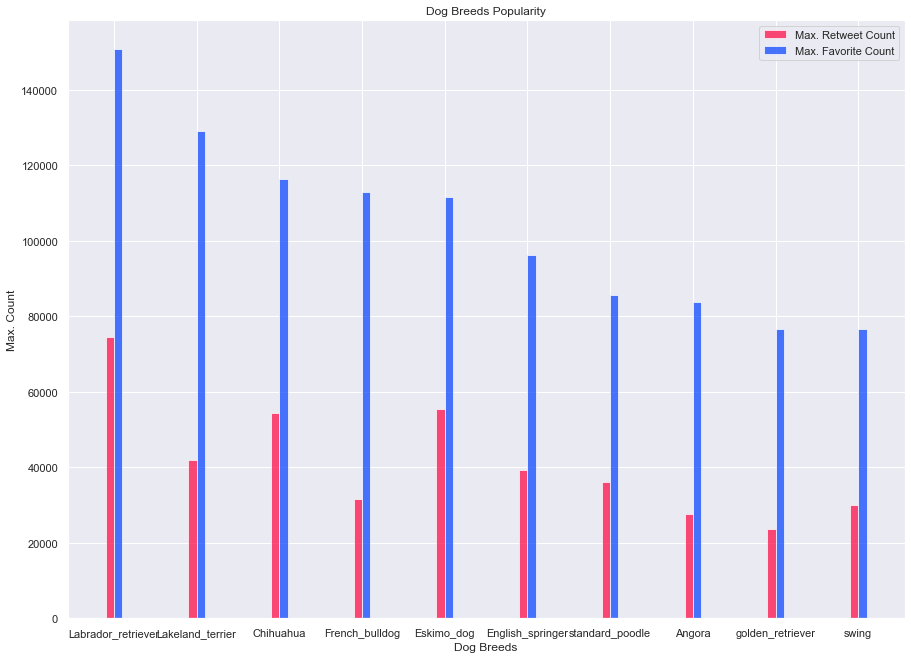

In [144]:
# Plot the maximum 'retweet_count' vs. 'favorite_count' for the Top 10 dog breeds
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(15,11)})
# Bar Width
width = 0.1
# X Locations for the groups 
ind = np.arange(len(breed_pop))

# plot bars
retweet_bars = plt.bar(ind, breed_pop['retweet_count'], width, color='#ff0040', alpha=.7, label='Max. Retweet Count')
fav_bars = plt.bar(ind + width, breed_pop['favorite_count'], width, color='#0040ff', alpha=.7, label='Max. Favorite Count')

# title and labels
plt.ylabel('Max. Count')
plt.xlabel('Dog Breeds')
plt.title('Dog Breeds Popularity')
locations = ind + width / 2  # xtick locations
labels = breed_pop.index # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend()
# Save resulting figure
plt.savefig('Dog_Breed_Popularity_1.png')

In [145]:
# Get the Minimum retweet and favorite count for each predicted dog breed (p1)
master_df.groupby('p1')[['retweet_count', 'favorite_count']].min()

,retweet_count,favorite_count
p1,,
Afghan_hound,1588.0,6240.0
African_crocodile,224.0,858.0
African_grey,1081.0,4677.0
African_hunting_dog,1013.0,1526.0
Airedale,71.0,195.0
...,...,...
wombat,333.0,1028.0
wood_rabbit,328.0,777.0
wooden_spoon,2878.0,14386.0


## Q3: What are the most loved dog breeds?

In [146]:
# Get the average rating for each predicted dog breed (p1)
# Sorted by 'rating_numerator' descendingly
master_df.groupby('p1')[['rating_numerator', 'rating_denominator']].mean().sort_values('rating_numerator', ascending = False)

,rating_numerator,rating_denominator
p1,,
bow_tie,451.500000,10.000000
microphone,420.000000,10.000000
lakeside,108.000000,90.000000
soft-coated_wheaten_terrier,26.700000,27.000000
teddy,18.588235,16.470588
...,...,...
maze,2.000000,10.000000
coho,2.000000,10.000000
slug,2.000000,10.000000


In [147]:
# Get the maximum rating for each predicted dog breed (p1)
# Sorted by 'rating_numerator' descendingly
master_df.groupby('p1')[['rating_numerator', 'rating_denominator']].max().sort_values('rating_numerator', ascending = False)

,rating_numerator,rating_denominator
p1,,
bow_tie,1776.0,10
microphone,420.0,10
lakeside,204.0,170
Labrador_retriever,165.0,150
teddy,144.0,120
...,...,...
slug,2.0,10
scorpion,2.0,10
coho,2.0,10


## Q4: How accurate are the dog breed classifications?

In [148]:
# Check the images that had the highest average ratings
master_df[master_df.p1 == 'bow_tie']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
722,749981277374128128,2016-07-04 15:00:45+00:00,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,10,Atticus,NaN,2381.0,...,1,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False
795,740365076218183684,2016-06-08 02:09:24+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When the photographer forgets to tell you where to look... 10/10 https://t.co/u1GHWxhC85,https://twitter.com/dog_rates/status/740365076218183684/photo/1,10.0,10,NaN,NaN,412.0,...,1,bow_tie,0.246313,False,Windsor_tie,0.172446,False,mushroom,0.137516,False
1143,694905863685980160,2016-02-03 15:30:43+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He's a Bisquick Taj Mapaw. Too many people are touching him. It is doing him a discomfort. 10/10 https://t.co/CJJpjTMzPQ,https://twitter.com/dog_rates/status/694905863685980160/photo/1,10.0,10,Archie,NaN,895.0,...,1,bow_tie,0.449268,False,fur_coat,0.139099,False,black-footed_ferret,0.082232,False
1740,670420569653809152,2015-11-28 01:54:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Damon. The newest presidential candidate for 2016. 10/10 he gets my vote https://t.co/Z5nqlfjYJi,https://twitter.com/dog_rates/status/670420569653809152/photo/1,10.0,10,Damon,NaN,288.0,...,1,bow_tie,0.268759,False,cardigan,0.153957,False,wig,0.072295,False


The image prediction `'bow_tie'` had the **highest average rating**, because one of the dogs 'Atticus' at `index = 722` in that classification had a really high rating `(1776/10)`, while the other 3 entries in that classification had only `(10/10)`.


*Note:* `bow_tie` is not a dog breed, which means these images were incorrectly classified, due to other dominant objects in the image.

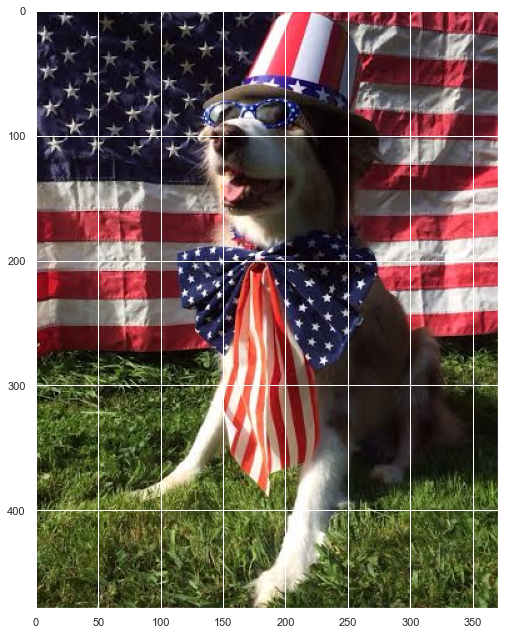

In [149]:
# Display the image that had the highest rating in 'bow_tie' classification
# Located at index = 722
img_url = master_df.iloc[722]['jpg_url']
img = plt.imread(img_url, format='jpg')
plt.imshow(img)
plt.show()

In [150]:
# Check the images that had the second highest average ratings
master_df[master_df.p1 == 'microphone']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1696,670842764863651840,2015-11-29 05:52:33+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,https://twitter.com/dog_rates/status/670842764863651840/photo/1,420.0,10,NaN,NaN,7983.0,...,1,microphone,0.096063,False,accordion,0.094075,False,drumstick,0.061113,False


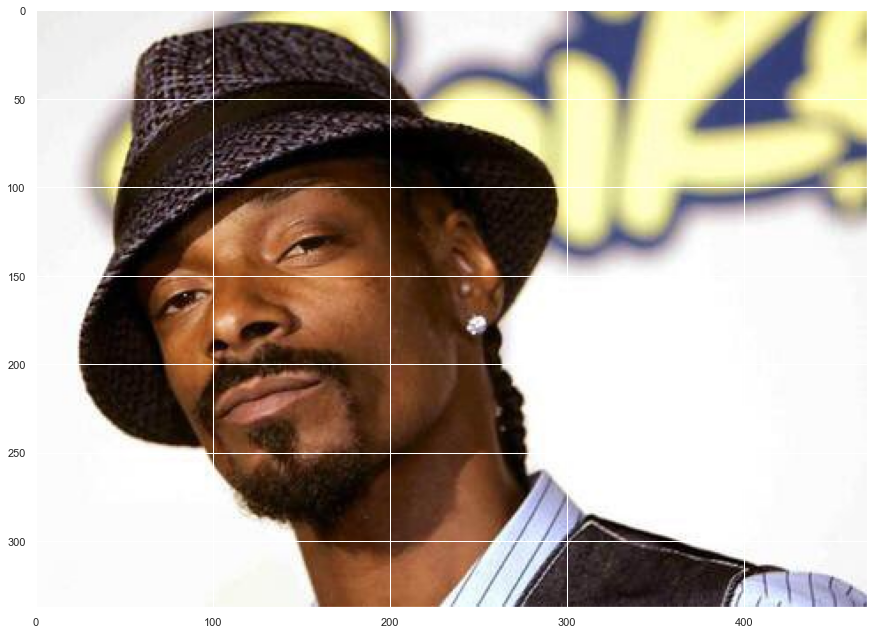

In [151]:
# Display the image that had the highest rating in 'microphone' classification
# Located at index = 1696 ==> Not a dog!
img_url = master_df.iloc[1696]['jpg_url']
img = plt.imread(img_url, format='jpg')
plt.imshow(img)
plt.show()

In [152]:
# Check the images that had the third highest average rating
master_df[master_df.p1 == 'lakeside']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
129,860276583193509888,2017-05-04 23:34:55+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jordy. He likes to go on adventures and watch the small scaly underwater dogs with fins pass him by. 12/10 peaceful as h*ck https://t.co/xJo6S2sfsN,https://twitter.com/dog_rates/status/860276583193509888/photo/1,12.0,10,Jordy,NaN,3213.0,...,1,lakeside,0.312299,False,dock,0.159842,False,canoe,0.070794,False
842,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204.0,170,this,NaN,1212.0,...,1,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False


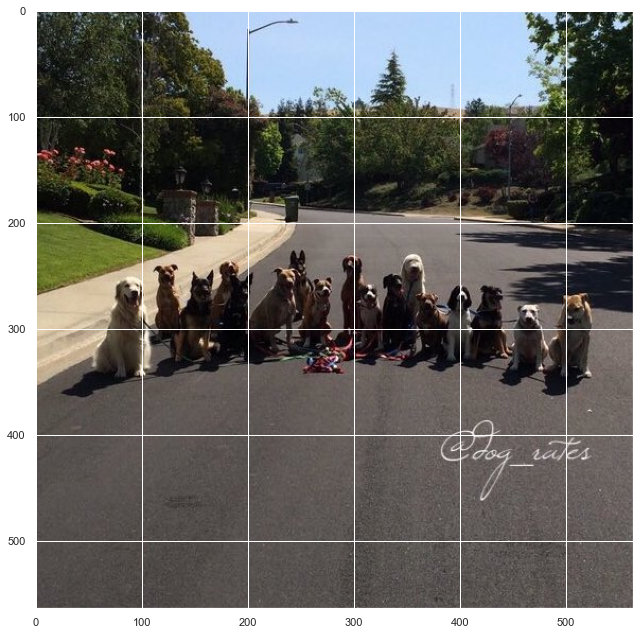

In [153]:
# Display the image that had the highest rating (204 / 170) in 'lakeside' classification
# Located at index = 842
img_url = master_df.iloc[842]['jpg_url']
img = plt.imread(img_url, format='jpg')
plt.imshow(img)
plt.show()

In [154]:
# Get the maximum rating for each predicted dog breed (p1)
# Sorted by 'rating_numerator' descendingly
master_df.groupby('p1')[['rating_numerator', 'rating_denominator']].max().sort_values('rating_numerator', ascending = False)

,rating_numerator,rating_denominator
p1,,
bow_tie,1776.0,10
microphone,420.0,10
lakeside,204.0,170
Labrador_retriever,165.0,150
teddy,144.0,120
...,...,...
slug,2.0,10
scorpion,2.0,10
coho,2.0,10


## Q5: What does the abnormal high ratings represent?

In [155]:
# Check the tweets that had the highest maximum ratings for a dog breed
master_df[master_df.p1 == 'Labrador_retriever'].sort_values('rating_numerator', ascending = False)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,retweet_count,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
658,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165.0,150,NaN,NaN,2145.0,...,1,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
1478,675853064436391936,2015-12-13 01:41:41+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,"https://twitter.com/dog_rates/status/675853064436391936/photo/1,https://twitter.com/dog_rates/status/675853064436391936/photo/1",88.0,80,NaN,NaN,1200.0,...,1,Labrador_retriever,0.868367,True,golden_retriever,0.043305,True,vizsla,0.028207,True
1120,697463031882764288,2016-02-10 16:51:59+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,https://twitter.com/dog_rates/status/697463031882764288/photo/1,44.0,40,NaN,NaN,1348.0,...,1,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True
410,803638050916102144,2016-11-29 16:33:36+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Pupper hath acquire enemy. 13/10 https://t.co/ns9qoElfsX,https://twitter.com/dog_rates/status/803638050916102144/video/1,13.0,10,NaN,pupper,4084.0,...,1,Labrador_retriever,0.372776,True,golden_retriever,0.343666,True,Great_Pyrenees,0.067242,True
331,818627210458333184,2017-01-10 01:15:10+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Wafer. He represents every fiber of my being. 13/10 very good dog https://t.co/I7bkhxBxUG,https://twitter.com/dog_rates/status/818627210458333184/photo/1,13.0,10,Wafer,NaN,7378.0,...,1,Labrador_retriever,0.384188,True,beagle,0.255917,True,grocery_store,0.079799,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,745422732645535745,2016-06-22 01:06:43+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. Pls stop sending in non-canines like this Jamaican Flop Seal. This is very very frustrating. 9/10 https://t.co/nc53zEN0hZ,https://twitter.com/dog_rates/status/745422732645535745/photo/1,9.0,10,very,NaN,2327.0,...,1,Labrador_retriever,0.663800,True,golden_retriever,0.308261,True,ice_bear,0.004269,False
1508,675111688094527488,2015-12-11 00:35:44+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Oliver. He thought what was inside the pillow should be outside the pillow. Blurry since birth. 8/10 https://t.co/lFU9W31Fg9,https://twitter.com/dog_rates/status/675111688094527488/photo/1,8.0,10,Oliver,NaN,232.0,...,1,Labrador_retriever,0.631501,True,Brittany_spaniel,0.101927,True,Chesapeake_Bay_retriever,0.062650,True
1851,668204964695683073,2015-11-21 23:10:52+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ron. Ron's currently experiencing a brain freeze. Damn it Ron. 8/10 https://t.co/4ilfcR5SlK,https://twitter.com/dog_rates/status/668204964695683073/photo/1,8.0,10,Ron,NaN,182.0,...,1,Labrador_retriever,0.655180,True,golden_retriever,0.107884,True,Chesapeake_Bay_retriever,0.065835,True
1929,666701168228331520,2015-11-17 19:35:19+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a golden Buckminsterfullerene named Johm. Drives trucks. Lumberjack (?). Enjoys wall. 8/10 would hug softly https

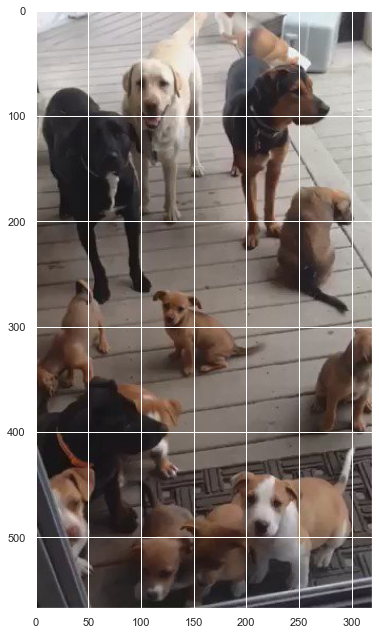

In [156]:
# Display the image that had the highest rating in 'Labrador_retriever' classification
# Located at index = 658
img_url = master_df.iloc[658]['jpg_url']
img = plt.imread(img_url, format='jpg')
plt.imshow(img)
plt.show()

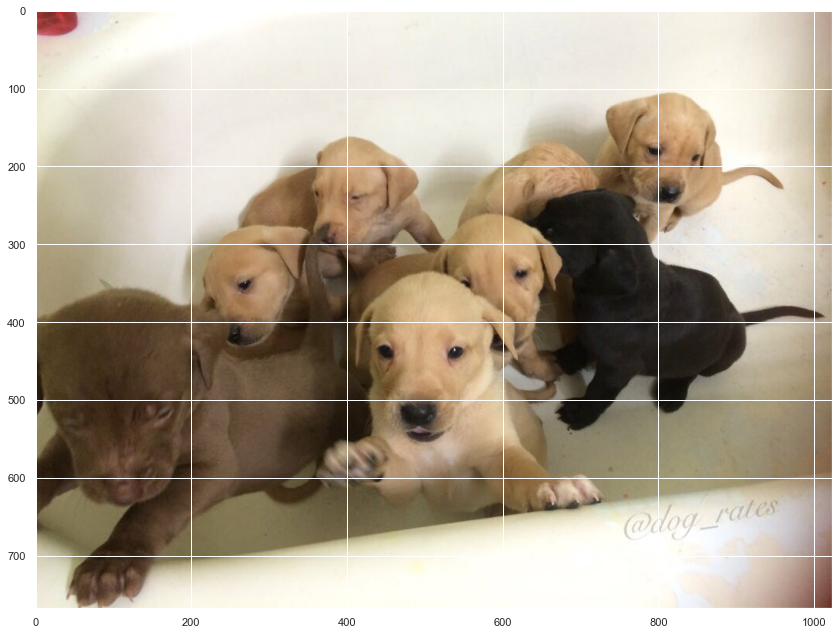

In [157]:
# Display the image that had the second highest rating in 'Labrador_retriever' classification
# Located at index = 1478
img_url = master_df.iloc[1478]['jpg_url']
img = plt.imread(img_url, format='jpg')
plt.imshow(img)
plt.show()

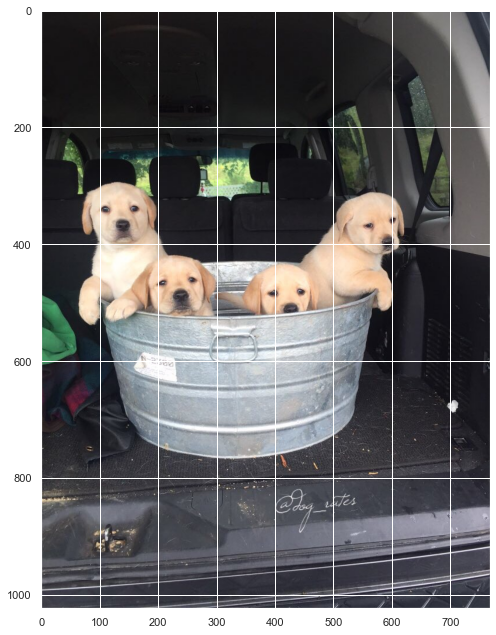

In [158]:
# Display the image that had the third highest rating in 'Labrador_retriever' classification
# Located at index = 1120
img_url = master_df.iloc[1120]['jpg_url']
img = plt.imread(img_url, format='jpg')
plt.imshow(img)
plt.show()

## Q6: What are the most popular Dog Stages?

In [159]:
# Get the count of each dog stage
stages_count = master_df.groupby('dog_stages').count()['tweet_id'].sort_values(ascending = False)
stages_count

dog_stages
pupper            201
doggo             63 
puppo             22 
doggo, pupper     8  
floofer           7  
doggo, floofer    1  
doggo, puppo      1  
Name: tweet_id, dtype: int64

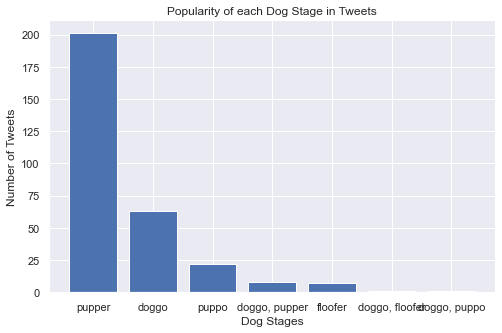

In [160]:
# Plot the count of each dog stage tweets
plt.subplots(figsize=(8, 5))
plt.bar(stages_count.index, stages_count)
plt.title('Popularity of each Dog Stage in Tweets')
plt.xlabel('Dog Stages')
plt.ylabel('Number of Tweets');
# Save resulting figure
plt.savefig('Dog_Stage_Count.png')

In [161]:
# Get the average 'retweet_count' and 'favorite_count' for each dog stage
avg_count_stage = master_df.groupby('dog_stages').mean()[['retweet_count', 'favorite_count']]
avg_count_stage

,retweet_count,favorite_count
dog_stages,,
doggo,6274.387097,18296.419355
"doggo, floofer",2937.000000,15414.000000
"doggo, pupper",3906.750000,13214.625000
"doggo, puppo",16795.000000,43337.000000
floofer,4174.428571,11669.714286
pupper,2025.179104,6506.248756
puppo,5593.772727,20323.409091


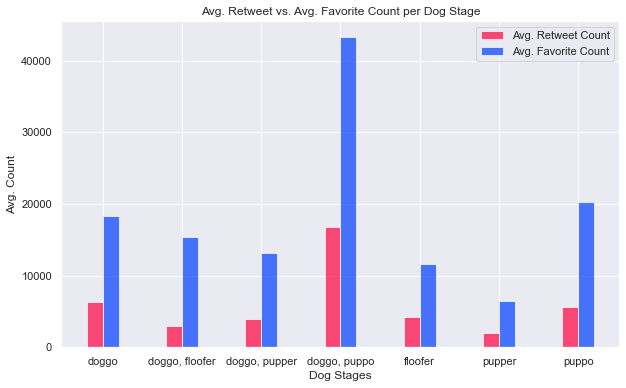

In [162]:
# Plot the average 'retweet_count' vs. 'favorite_count' for each dog stage
sns.set_context(context='notebook')
sns.set(rc={'figure.figsize':(10,6)})
# Bar Width
width = 0.2
# X Locations for the groups 
ind = np.arange(len(avg_count_stage))

# plot bars
retweet_bars = plt.bar(ind, avg_count_stage['retweet_count'], width, color='#ff0040', alpha=.7, label='Avg. Retweet Count')
fav_bars = plt.bar(ind + width, avg_count_stage['favorite_count'], width, color='#0040ff', alpha=.7, label='Avg. Favorite Count')

# title and labels
plt.ylabel('Avg. Count')
plt.xlabel('Dog Stages')
plt.title('Avg. Retweet vs. Avg. Favorite Count per Dog Stage')
locations = ind + width / 2  # xtick locations
labels = avg_count_stage.index # xtick labels
plt.xticks(locations, labels)

# legend
plt.legend()
# Save resulting figure
plt.savefig('Dog_Stage_Popularity.png')